In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from copy import deepcopy
from torch.utils.data import Dataset, DataLoader

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', filename='ratings_train.txt' )
urllib.request.urlretrieve('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', filename='ratings_test.txt' )

('ratings_test.txt', <http.client.HTTPMessage at 0x7fed5190db70>)

In [ ]:
train_dataset = pd.read_table('ratings_train.txt')
train_dataset

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
# pos, nag 비율
train_dataset['label'].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

In [ ]:
sum(train_dataset['document'].isnull())

5

In [ ]:
# ~는 논리 부정 연산자(NOT)를 의미
~train_dataset['document'].isnull()

0         True
1         True
2         True
3         True
4         True
          ... 
149995    True
149996    True
149997    True
149998    True
149999    True
Name: document, Length: 150000, dtype: bool

In [ ]:
# 결측값삭제
train_dataset = train_dataset[~train_dataset['document'].isnull()]

In [ ]:
# 결측값 확인: 0
sum(train_dataset['document'].isnull())

0

In [ ]:
# 데이터프레임 확인 (5개 행 삭제)
train_dataset

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### Tokenization
* 자연어를 모델이 이해하기 위해서는 자연어를 숫자의 형식으로 변형 시켜야 함

In [ ]:
# 'document' 열에서 첫 번째 행의 문자열을 공백을 기준으로 분리
# iloc[0]는 pandas 데이터프레임에서 첫 번째 행을 선택
train_dataset['document'].iloc[0].split()

['아', '더빙..', '진짜', '짜증나네요', '목소리']

In [ ]:
vocab = set()
for doc in train_dataset['document']:
    for token in doc.split():
        vocab.add(token)

In [ ]:
len(vocab)

357862

In [ ]:
# 단어의 빈도수를 구하기
'''
[('아', 1204),
 ('더빙..', 2),
 ('진짜', 5929),
 ('짜증나네요', 10),
 ('목소리', 99),
 ...
]
'''
vocab_cnt_dict = {}
for doc in train_dataset['document']:
    for token in doc.split():
        if token not in vocab_cnt_dict:
            vocab_cnt_dict[token] = 0
        vocab_cnt_dict[token] += 1

In [ ]:
vocab_cnt_list = [(token, cnt) for token, cnt in vocab_cnt_dict.items()]

In [ ]:
vocab_cnt_list[:10]

[('아', 1204),
 ('더빙..', 2),
 ('진짜', 5929),
 ('짜증나네요', 10),
 ('목소리', 99),
 ('흠...포스터보고', 1),
 ('초딩영화줄....오버연기조차', 1),
 ('가볍지', 17),
 ('않구나', 2),
 ('너무재밓었다그래서보는것을추천한다', 1)]

In [ ]:
# [ vocab_cnt_list ] 등장 횟수 내림차순 정렬
# lambda tup: tup[1]를 사용하여 튜플의 두 번째 요소(빈도수)를 기준으로 정렬
top_vocabs = sorted(vocab_cnt_list, key=lambda tup: tup[1], reverse=True)

In [ ]:
top_vocabs

[('영화', 10825),
 ('너무', 8239),
 ('정말', 7791),
 ('진짜', 5929),
 ('이', 5059),
 ('영화.', 3598),
 ('왜', 3285),
 ('더', 3260),
 ('이런', 3249),
 ('그냥', 3237),
 ('수', 2945),
 ('영화를', 2759),
 ('잘', 2644),
 ('다', 2615),
 ('보고', 2557),
 ('좀', 2449),
 ('영화는', 2426),
 ('그', 2421),
 ('영화가', 2418),
 ('본', 2298),
 ('최고의', 2219),
 ('ㅋㅋ', 2019),
 ('내가', 2000),
 ('없는', 1957),
 ('이건', 1889),
 ('이렇게', 1828),
 ('완전', 1780),
 ('평점', 1760),
 ('봤는데', 1746),
 ('있는', 1739),
 ('좋은', 1726),
 ('이거', 1710),
 ('이게', 1676),
 ('보는', 1600),
 ('평점이', 1595),
 ('내', 1595),
 ('다시', 1583),
 ('그리고', 1547),
 ('참', 1508),
 ('많이', 1478),
 ('역시', 1466),
 ('난', 1405),
 ('연기', 1365),
 ('재밌게', 1343),
 ('한', 1323),
 ('쓰레기', 1295),
 ('것', 1277),
 ('하는', 1236),
 ('또', 1231),
 ('아', 1204),
 ('드라마', 1186),
 ('꼭', 1181),
 ('가장', 1178),
 ('보면', 1176),
 ('ㅋㅋㅋ', 1108),
 ('마지막', 1070),
 ('스토리', 1020),
 ('무슨', 999),
 ('ㅋ', 989),
 ('없고', 981),
 ('.', 981),
 ('볼', 959),
 ('ㅠㅠ', 958),
 ('같은', 956),
 ('없다.', 950),
 ('끝까지', 940),
 ('대한', 936),
 ('안', 

In [ ]:
# 단어 등장 횟수 리스트로 저장
cnts = [cnt for _, cnt in top_vocabs]

In [ ]:
# 단어 등장 횟수 평균값
np.mean(cnts)

3.1792590439890236

In [ ]:
# 처음부터 10개의 원소 출력
cnts[:10]

[10825, 8239, 7791, 5929, 5059, 3598, 3285, 3260, 3249, 3237]

In [ ]:
# cnts 리스트로 변환, 등장횟수가 3이상인 단어 개수
sum(np.array(cnts) > 2)

42635

In [ ]:
# 결과를 n_vocab에 저장
n_vocab = sum(np.array(cnts) > 2)

In [ ]:
n_vocab

42635

In [ ]:
# [ top_vocabs_truncated ]  top_vocabs에서 처음 n_vocab 개의 항목을 추출해 할당
top_vocabs_truncated = top_vocabs[:n_vocab]

In [ ]:
# 리스트의 처음 5개 항목을 출력
top_vocabs_truncated[:5]

[('영화', 10825), ('너무', 8239), ('정말', 7791), ('진짜', 5929), ('이', 5059)]

In [ ]:
# 단어만 변수로 따로 담음
# [ vocabs ] top_vocabs_truncated 리스트에서 각 요소의 첫 번째 요소를 추출하여 할당,
vocabs = [token for token, _ in top_vocabs_truncated]
vocabs[:5]

['영화', '너무', '정말', '진짜', '이']

### special token
* [UNK]: Unknown token
* [PAD]: Padding token


In [ ]:
# [UNK]와 [PAD] 토큰이 어휘 목록인 vocabs에 포함되어 있는지를 확인
unk_token = '[UNK]'
unk_token in vocabs
# 당연히 없음

False

In [ ]:
pad_token = '[PAD]'
pad_token in vocabs
# 당연히 없음

False

In [ ]:
# [ vocabs  ] 맨 앞에 unk_token과 pad_token을 삽입
vocabs.insert(0, unk_token)
vocabs.insert(0, pad_token)

In [ ]:
vocabs[:5]

['[PAD]', '[UNK]', '영화', '너무', '정말']

In [ ]:
# [ idx_to_token ] 인덱스를 토큰으로 매핑
# [ token_to_idx ] 토큰을 인덱스로 매핑하는 사전
idx_to_token = vocabs
token_to_idx = {token: i for i, token in enumerate(idx_to_token)}

In [ ]:
idx_to_token[:5]

['[PAD]', '[UNK]', '영화', '너무', '정말']

In [ ]:
print(token_to_idx)

{'[PAD]': 0, '[UNK]': 1, '영화': 2, '너무': 3, '정말': 4, '진짜': 5, '이': 6, '영화.': 7, '왜': 8, '더': 9, '이런': 10, '그냥': 11, '수': 12, '영화를': 13, '잘': 14, '다': 15, '보고': 16, '좀': 17, '영화는': 18, '그': 19, '영화가': 20, '본': 21, '최고의': 22, 'ㅋㅋ': 23, '내가': 24, '없는': 25, '이건': 26, '이렇게': 27, '완전': 28, '평점': 29, '봤는데': 30, '있는': 31, '좋은': 32, '이거': 33, '이게': 34, '보는': 35, '평점이': 36, '내': 37, '다시': 38, '그리고': 39, '참': 40, '많이': 41, '역시': 42, '난': 43, '연기': 44, '재밌게': 45, '한': 46, '쓰레기': 47, '것': 48, '하는': 49, '또': 50, '아': 51, '드라마': 52, '꼭': 53, '가장': 54, '보면': 55, 'ㅋㅋㅋ': 56, '마지막': 57, '스토리': 58, '무슨': 59, 'ㅋ': 60, '없고': 61, '.': 62, '볼': 63, 'ㅠㅠ': 64, '같은': 65, '없다.': 66, '끝까지': 67, '대한': 68, '안': 69, '만든': 70, '솔직히': 71, '넘': 72, '봐도': 73, '말이': 74, '하지만': 75, '전혀': 76, '뭐': 77, '10점': 78, '영화의': 79, '내내': 80, '아주': 81, '최악의': 82, '지금': 83, '..': 84, 'ㅎㅎ': 85, '할': 86, '다른': 87, '뭔가': 88, '그래도': 89, '재미있게': 90, '어떻게': 91, '많은': 92, '최고': 93, '영화..': 94, '연기가': 95, '별': 96, '중': 97, '재미': 98, '이걸': 99, 

In [ ]:
# 클래스 Tokenizer | 텍스트를 토큰 ID의 리스트로 변환
# 단어 사전(vocabs)을 사용하여 토큰을 인덱스로 매핑하고, 선택적으로 패딩을 적용
class Tokenizer:
    def __init__(self, vocabs, use_padding=True, max_padding=64, pad_token='[PAD]', unk_token='[UNK]'):
        self.idx_to_token = vocabs
        self.token_to_idx = {token: i for i, token in enumerate(self.idx_to_token)}
        self.use_padding = use_padding
        self.max_padding = max_padding
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.unk_token_idx = self.token_to_idx[self.unk_token]
        self.pad_token_idx = self.token_to_idx[self.pad_token]

    def __call__(self, x:str):
        token_ids = []
        token_list = x.split()
        for token in token_list:
            if token in self.token_to_idx:
                token_idx = self.token_to_idx[token]
            else:
                token_idx = self.unk_token_idx
            token_ids.append(token_idx)

        if self.use_padding:
            token_ids = token_ids[:self.max_padding]
            n_pads = self.max_padding - len(token_ids)
            token_ids = token_ids + [self.pad_token_idx] * n_pads
        return token_ids

In [ ]:
tokenizer = Tokenizer(vocabs, use_padding=False)

In [ ]:
# train_dataset에서 첫 번째 문서를 가져와 출력
sample = train_dataset['document'].iloc[0]  # 첫번째문장
print(sample)

아 더빙.. 진짜 짜증나네요 목소리


In [ ]:
# 이를 tokenizer를 사용하여 토큰 ID 리스트로 변환
tokenizer(sample)  # [51, 1, 5, 10485, 1064]

[51, 1, 5, 10485, 1064]

In [ ]:
# train_dataset의 'document' 열에 있는 모든 문서를 순회하면서 각 문서를 토큰화
# 토큰 리스트의 길이를 [ token_length_list ] 에 저장
token_length_list = []
for sample in train_dataset['document']:
    token_length_list.append(len(tokenizer(sample)))

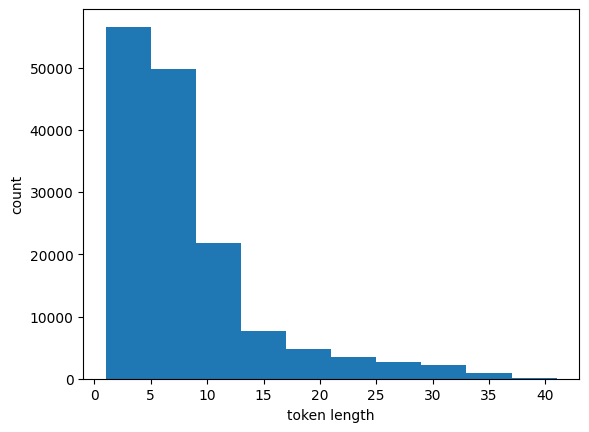

In [ ]:
# [ token_length_list ]  토큰 길이의 분포를 시각화
plt.hist(token_length_list)
plt.xlabel('token length')
plt.ylabel('count')
plt.show()

In [ ]:
max(token_length_list)  # 41개가 가장 긴것

41

In [ ]:
# 최대 길이 50으로 패딩을 추가하는 토크나이저를 생성
tokenizer = Tokenizer(vocabs, use_padding=True, max_padding=50)
# use_padding=True: 토크나이저가 패딩을 사용할지 여부를 설정하는 옵션=>패딩을 사용하도록 설정
# max_padding=50: 패딩을 사용할 때, 문장의 최대 길이를 50으로 설정하는 옵션
# =>문장의 길이가 50보다 짧으면 패딩을 추가하고, 50보다 길면 잘라내는 역할

In [ ]:
print(tokenizer(sample))
# 뒤에 0,0, 패딩으로 채워진

[201, 2, 3635, 1, 121, 1946, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# 훈련 및 검증 데이터 불러오기
train_valid_dataset = pd.read_table('ratings_train.txt')
test_dataset = pd.read_table('ratings_test.txt')

In [ ]:
# 데이터셋에 포함된 항목의 개수 출력
print(f'train, valid samples: {len(train_valid_dataset)}')
print(f'test samples: {len(test_dataset)}')

train, valid samples: 150000
test samples: 50000


In [ ]:
train_valid_dataset.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# 데이터프레임을 무작위로 섞기
# sample(frac=1.): 데이터프레임의 행을 무작위로 샘플링
# frac=1.는 데이터프레임의 전체 행을 선택
train_valid_dataset = train_valid_dataset.sample(frac=1.)
train_valid_dataset.head()  # 섞임

,id,document,label
18399,4976647,포스터로 낚시는 이제 그만..얀센 연기빼고 볼게 하나도 음네...쯥..,0
70354,3688950,헐,0
9000,9555936,자수하면 9년 정도 살 텐데 그럼 둘의 나이는 20대 후반이겠고 새출발 하기에 충분...,1
60759,8471952,아이가봐도 지루해하지않아좋아요중간중간 코믹하고 음악도좋구요,1
113553,3372657,평점 좋길래 다운받아봤다가...... 이뭐병....ㅡㅡ,0


In [ ]:
# train_valid_dataset | 훈련 데이터셋(80%) 검증 데이터셋(20%)
train_ratio = 0.8
n_train = int(len(train_valid_dataset) * train_ratio)
train_df = train_valid_dataset[:n_train] # 처음부터 n_train
valid_df = train_valid_dataset[n_train:] # n_train부터 끝
test_df = test_dataset  # 이름 맞추기

In [ ]:
print(f'train samples: {len(train_df)}')
print(f'valid samples: {len(valid_df)}')
print(f'test samples: {len(test_df)}')

train samples: 120000
valid samples: 30000
test samples: 50000


In [ ]:
# 훈련 / 검증 / 테스트 데이터셋 | 10%씩 무작위로 샘플링
# 1/10으로 샘플링
# frac=0.1는 전체 데이터의 10%를 샘플링한다는 의미
train_df = train_df.sample(frac=0.1)
valid_df = valid_df.sample(frac=0.1)
test_df = test_df.sample(frac=0.1)

In [ ]:
print(f'train samples: {len(train_df)}')
print(f'valid samples: {len(valid_df)}')
print(f'test samples: {len(test_df)}')
# 1/10으로 줄어있음

train samples: 12000
valid samples: 3000
test samples: 5000


In [ ]:
# 클래스 : NSMCDataset 훈련, 검증 및 테스트 데이터셋을 생성
class NSMCDataset(Dataset):
    def __init__(self, data_df, tokenizer=None):
        self.data_df = data_df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data_df)

    # doc, label, doc_ids
    def __getitem__(self, idx):
        sample_raw = self.data_df.iloc[idx]
        sample = {}
        sample['doc'] = str(sample_raw['document'])
        sample['label'] = sample_raw['label']
        if self.tokenizer is not None:
            sample['doc_ids'] = self.tokenizer(sample['doc'])
        return sample

In [ ]:
train_dataset = NSMCDataset(data_df=train_df, tokenizer=tokenizer)
valid_dataset = NSMCDataset(data_df=valid_df, tokenizer=tokenizer)
test_dataset = NSMCDataset(data_df=test_df, tokenizer=tokenizer)

In [ ]:
print(train_dataset[0])

{'doc': '구구구극?극?ㄱㅅ굿굿', 'label': 1, 'doc_ids': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
# 함수: collate_fn 여러 샘플을 하나의 배치(batch)로 병합
def collate_fn(batch):
    keys = [key for key in batch[0].keys()]
    data = {key: [] for key in keys}
    for item in batch:
        for key in keys:
            data[key].append(item[key])
    return data

In [ ]:
# DataLoader  |  훈련 / 검증 / 테스트 데이터셋을 배치로 로드
# DataLoader는 PyTorch의 데이터 유틸리티로, 데이터셋을 효율적으로 불러오고,
# 미니 배치로 나누고, 순서를 무작위로 섞는 등의 작업을 수행
train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=128,
    collate_fn=collate_fn,
    shuffle=False
)

In [ ]:
# 문서 / 레이블 /  토큰화된 문서 ID  (토크나이저가 주어진 경우) 출력
# iter() 함수는 DataLoader 객체를 반복 가능(iterable) 객체로 변환
# next() 함수는 이 반복 가능한 객체에서 다음 항목을 가져옴
sample = next(iter(test_dataloader))

In [ ]:
sample.keys()  # dict_keys(['doc', 'label', 'doc_ids'])

dict_keys(['doc', 'label', 'doc_ids'])

In [ ]:
sample['doc'][3]  # 정말 재미지게 오랫동안 보게된는 드라마

'괜히봤다 이세상 강간범들 똥구멍 똑같이 다 찢어놔야되'

In [ ]:
print(sample['doc_ids'][2]) # [4, 17366, 2223, 2798, 52, ]

[11, 15104, 118, 3400, 287, 31, 5753, 1, 706, 715, 5, 6168, 92, 18920, 1, 1454, 1, 224, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### CBOW(Continuous Bag of Words)
* 자연어 처리에서 단어의 의미를 벡터로 표현하는 Word2Vec 모델 중 하나
* 문맥(context) 단어들을 사용해서 타켓(target) 단어를 예측하는 것
* 모델의 원리
    * 문장은 단어의 연속으로 구성
        * 예) the cat sat on the mat
        * 타겟단어: cat, 주변 단어 ('The', 'sat')
    * 문맥 단어의 수를 결정하는 윈도우 크기를 설정
        * 예) 윈도우 크기: 2, 타겟 단어의 왼쪽과 오른쪽에서 각각 2개의 단어를 문맥 단어로 사용
    * 모든 단어를 고유한 인덱스로 매핑하고 원 핫 인코딩으로 변환
    * 입력으로 주어진 문맥 단어들을 이용해 타겟 단어를 예측하는 신경망을 학습
        * 예) 일반적으로 입력층, 은닉층, 출력층 3개의 층으로 구성
        * 입력층: 문맥 단어들의 원 핫 인코딩 벡터를 받음
        * 은닉층: 입력 벡터들의 평균을 계산하여 은닉층 벡터를 만듦
        * 출력층: 은닉증 벡터를 사용해 타겟 단어를 예측

In [ ]:
# 클래스 :  CBOW (Continuous Bag of Words)
# 주변 단어들을 사용하여 중심 단어를 예측하는 모델
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.output_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

    def forward(self, x):
        # (batch_size, sequence) -> (batch_size, sequence, embed_dim)
        x_embeded = self.embedding(x)
        stnc_repr = torch.mean(x_embeded, dim=1) # batch_size * embed_dim
        return stnc_repr

In [ ]:
# 클래스: Classifier 분류기 모델
# 주어진 단어 임베딩 모델(sr_model)을 기반으로 하여 분류 작업 수행
class Classifier(nn.Module):
  def __init__(self, sr_model, output_dim, vocab_size, embed_dim, **kwargs):
    super().__init__()
    self.sr_model = sr_model(vocab_size=vocab_size, embed_dim=embed_dim, **kwargs)
    self.input_dim = self.sr_model.output_dim
    self.output_dim = output_dim
    self.fc = nn.Linear(self.input_dim,  self.output_dim)

  def forward(self, x):
    return self.fc(self.sr_model(x))

In [ ]:
# CBOW 모델을 사용하여 단어 임베딩을 구성하고, 이를 기반으로 분류를 수행
model = Classifier(sr_model=CBOW, output_dim=2, vocab_size=len(vocabs), embed_dim=16)
# Classifier 클래스의 인스턴스를 생성.
# sr_model=CBOW: Classifier 클래스의 생성자에 CBOW 클래스를 전달하여 단어 임베딩 모델로 사용
# 즉, CBOW 클래스가 단어 임베딩을 담당하는 모델로 설정
# output_dim=2: 분류기의 출력 차원을 2로 설정. 이는 분류 문제에서 출력 클래스의 개수를 나타냅
# vocab_size=len(vocabs): 어휘 사전의 크기를 설정.
# embed_dim=16: 단어 임베딩의 차원을 16으로 설정. 각 단어는 16차원의 실수 벡터로 표현

In [ ]:
model.sr_model.embedding.weight[1]

tensor([ 0.3521,  1.4134,  0.3344,  0.4394, -0.5204,  1.4955,  0.9981,  0.1187,
         0.6956,  1.2387, -0.3916, -2.4659,  1.2960, -2.8463, -1.9364,  0.6505],
       grad_fn=<SelectBackward0>)

In [ ]:
# CUDA 사용 가능 여부를 확인, 가능한 경우 모델을 GPU로 이동
use_cuda = True and torch.cuda.is_available()

if use_cuda:
    model = model.cuda()

In [ ]:
# 학습에 필요한 최적화 함수와 손실 함수를 설정
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
calc_loss = nn.CrossEntropyLoss()
CrossEntropyLoss는 분류 문제를 해결할 때 주로 사용하는 손실 함수. 주로 다중 클래스 분류 문제에서 사용

In [ ]:
n_epoch = 10
global_i = 0

valid_loss_history = []
train_loss_history = []

best_model = None
best_epoch_i = None
min_valid_loss = 9e+9

for epoch_i in range(n_epoch):
    model.train()

    for batch in train_dataloader:
        optimizer.zero_grad()
        X = torch.tensor(batch['doc_ids'])
        y = torch.tensor(batch['label'])

        if use_cuda:
            X = X.cuda()
            y = y.cuda()

        y_pred = model(X)
        loss = calc_loss(y_pred, y)

        if global_i % 1000 == 0:
            print(f'i: {global_i}, epoch: {epoch_i}, loss: {loss.item()}')

        train_loss_history.append((global_i, loss.item()))

        loss.backward()
        optimizer.step()
        global_i += 1
    # model.eval()은 PyTorch에서 모델을 평가 모드(evaluation mode)로 전환하는 메서드
    model.eval()

    valid_loss_list = []
    for batch in valid_dataloader:
        X = torch.tensor(batch['doc_ids'])
        y = torch.tensor(batch['label'])

        if use_cuda:
            X = X.cuda()
            y = y.cuda()

        y_pred = model(X)
        loss = calc_loss(y_pred, y)
        valid_loss_list.append(loss.item())

    valid_loss_mean = np.mean(valid_loss_list)
    valid_loss_history.append((global_i, valid_loss_mean.item()))

    if valid_loss_mean < min_valid_loss:
        min_valid_loss = valid_loss_mean
        best_epoch_i = epoch_i
        best_model = deepcopy(model)

    if epoch_i % 2 == 0:
        print("*"*30)
        print(f'valid_loss_mean: {valid_loss_mean}')
        print("*"*30)

print(f'best_epoch: {best_epoch_i}')

i: 0, epoch: 0, loss: 0.6910268068313599
******************************
valid_loss_mean: 0.66302922864755
******************************
******************************
valid_loss_mean: 0.5263810331622759
******************************
******************************
valid_loss_mean: 0.5322575867176056
******************************
******************************
valid_loss_mean: 0.5714271801213423
******************************
******************************
valid_loss_mean: 0.6228969370325407
******************************
best_epoch: 3


In [ ]:
# 훈련과 검증 손실의 추이를 시각화
def calc_moving_average(arr, win_size=100):
    new_arr = []
    win = []
    for i, val in enumerate(arr):
        win.append(val)
        if len(win) > win_size:
            win.pop(0)
        new_arr.append(np.mean(win))
    return np.array(new_arr)

Text(0, 0.5, 'loss')

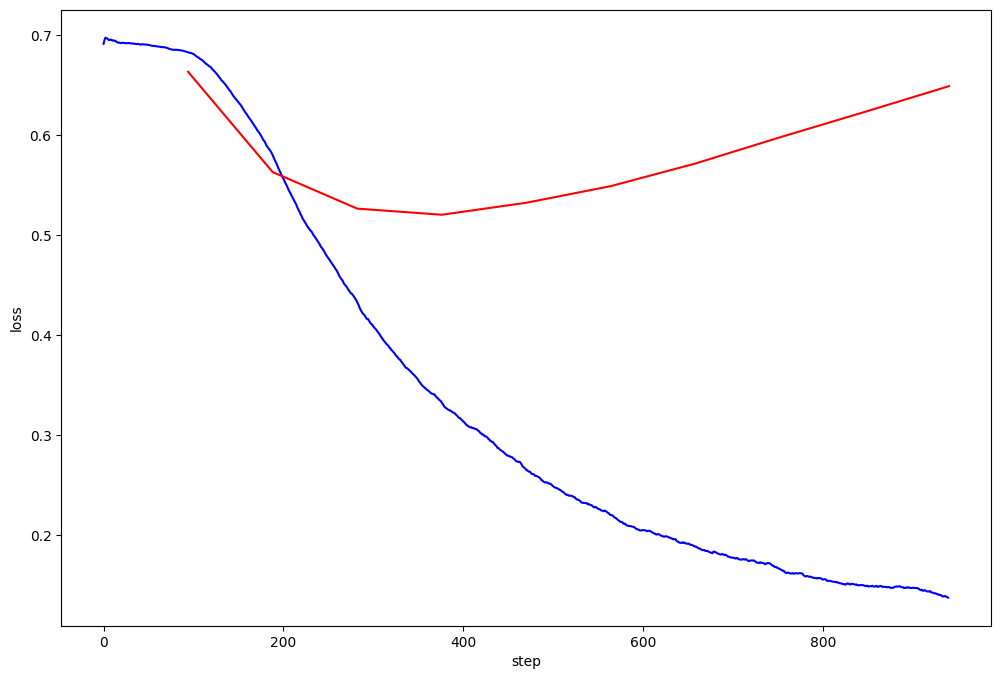

In [ ]:
valid_loss_history = np.array(valid_loss_history)
train_loss_history =  np.array(train_loss_history)
plt.figure(figsize=(12,8))
plt.plot(train_loss_history[:,0],
         calc_moving_average(train_loss_history[:,1]), color='blue')
plt.plot(valid_loss_history[:,0],
         valid_loss_history[:,1], color='red')
plt.xlabel("step")
plt.ylabel("loss")
# valid_loss_history: 점점 과적합됨
# train_loss_history: 성능이 점점 좋아짐

In [ ]:
# 테스트 데이터셋에서 정확도를 계산
model = best_model

model.eval()

total = 0
correct = 0

for batch in tqdm(test_dataloader,
                  total=len(test_dataloader.dataset)//test_dataloader.batch_size):
    X = torch.tensor(batch['doc_ids'])
    y = torch.tensor(batch['label'])

    if use_cuda:
        X = X.cuda()
        y = y.cuda()

    y_pred = model(X)

    curr_correct = y_pred.argmax(dim=1) == y

    total += len(curr_correct)
    correct += sum(curr_correct)

print(f'text accuracy: {correct/total}')

40it [00:00, 47.04it/s]

text accuracy: 0.722000002861023
